In [1]:
%cd /data1/yokoyama/labvideo
import os
import re
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sys.path.append("src")
from utils import json_handler

/data1/yokoyama/anaconda3/envs/labvideo/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/data1/yokoyama/labvideo


In [2]:
ann_json_path = "annotation/annotation.json"
ann_json = json_handler.load(ann_json_path)
info_json = json_handler.load("annotation/info.json")

In [3]:
pattern = "(?<=\().+?(?=\))"
# pattern = "\(.*?\)"

transitions_all = []
for video_id, ann_data in ann_json.items():
    if video_id not in info_json:
        print(f"{video_id} is not in info.json")
        continue

    transitions = [(-1, "START")]
    for ann in ann_data:
        if ann["type"] == "TextComment":
            if "終了" not in ann["text"]:
                count = int(ann["text"].split("(")[0])
                label = re.findall(pattern, ann["text"])
                if len(label) > 0:
                    label = f"{label[0]}_S"
                    transitions.append((count, label))
                else:
                    transitions.append((None, "ERROR"))
            else:
                count_str = ann["text"].replace("終了", "")
                for count in count_str.split(","):
                    count = int(count)
                    label = [data[1] for data in transitions if data[0] == count][0].split("_")[0]
                    label = f"{label}_E"
                    transitions.append((count, label))
    else:
        transitions.append((-1, "END"))

    pre_data = transitions[0]
    for data in transitions[1:]:
        transitions_all.append([pre_data[1], data[1]])
        pre_data = data

print(transitions_all)

3mM4jS3gBvTK2P is not in info.json
3srKEshkT3fLGM is not in info.json
3pcndHnN6HTNdd is not in info.json
3sv2B2Dd5LPKeo is not in info.json
3ss4tuEPwjBtvN is not in info.json
3mM4QBY4abCitk is not in info.json
3pdXwv2TauKeQV is not in info.json
[['START', 'C42_S'], ['C42_S', 'C42_E'], ['C42_E', 'B41_S'], ['B41_S', 'A12_S'], ['A12_S', 'A12_E'], ['A12_E', 'A22_S'], ['A22_S', 'A22_E'], ['A22_E', 'A36_S'], ['A36_S', 'B41_E'], ['B41_E', 'END'], ['START', 'A34_S'], ['A34_S', 'A34_E'], ['A34_E', 'C31_S'], ['C31_S', 'A36_S'], ['A36_S', 'A36_E'], ['A36_E', 'END'], ['START', 'A34_S'], ['A34_S', 'A34_E'], ['A34_E', 'B24_S'], ['B24_S', 'A36_S'], ['A36_S', 'A36_E'], ['A36_E', 'END'], ['START', 'A34_S'], ['A34_S', 'A34_E'], ['A34_E', 'A22_S'], ['A22_S', 'A32_S'], ['A32_S', 'A32_E'], ['A32_E', 'END'], ['START', 'A21_S'], ['A21_S', 'A23_S'], ['A23_S', 'A21_E'], ['A21_E', 'A23_E'], ['A23_E', 'END'], ['START', 'A11_S'], ['A11_S', 'A11_S'], ['A11_S', 'A12_S'], ['A12_S', 'A12_E'], ['A12_E', 'A13_S'], ['A1

In [4]:
transitions_all = np.array(transitions_all).T

In [5]:
# sort labels
labels = np.unique(transitions_all).tolist()
labels.remove("START")
labels.remove("END")
if "ERROR" in labels:
    labels.remove("ERROR")
labels = sorted(labels, key= lambda x: x.split("_")[1], reverse=True)
labels = sorted(labels, key= lambda x: x.split("_")[0])
labels = ["START"] + labels + ["ERROR", "END"]

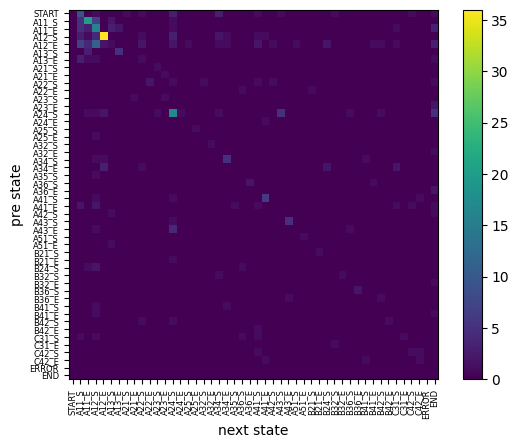

In [7]:
cm = confusion_matrix(transitions_all[0], transitions_all[1], labels=labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(xticks_rotation="vertical", include_values=False)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel("next state")
plt.ylabel("pre state")
path = "out/transition_matrix/transition_matrix.jpg"
os.makedirs(os.path.dirname(path), exist_ok=True)
plt.savefig(path, bbox_inches="tight")
plt.show()

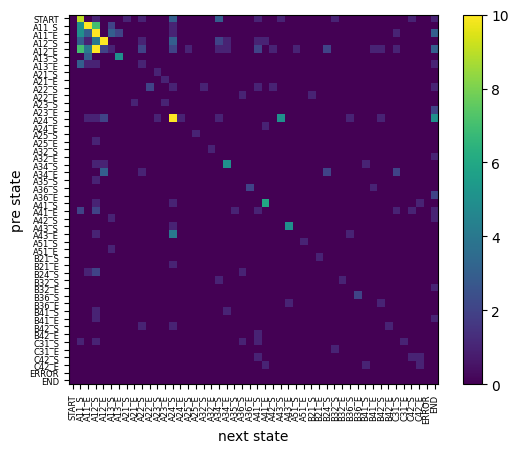

In [9]:
clip_max = 10
cm = confusion_matrix(transitions_all[0], transitions_all[1], labels=labels)
cm = np.clip(cm, 0, clip_max)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(xticks_rotation="vertical", include_values=False)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel("next state")
plt.ylabel("pre state")
plt.savefig(f"out/transition_matrix/transition_matrix_clip{clip_max}.jpg", bbox_inches="tight")
plt.show()

In [ ]:
# cm = confusion_matrix(transitions_all[0], transitions_all[1], labels=labels, normalize="all")
# cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
# cmd.plot(xticks_rotation="vertical", include_values=False)
# plt.xticks(fontsize=6)
# plt.yticks(fontsize=6)
# plt.xlabel("next state")
# plt.ylabel("pre state")
# plt.show()